MSE: 0.13156163120429512
MAE: 0.3213476160164611
RMSE: 0.36271425558460635
MAPE: 10.711587200548705


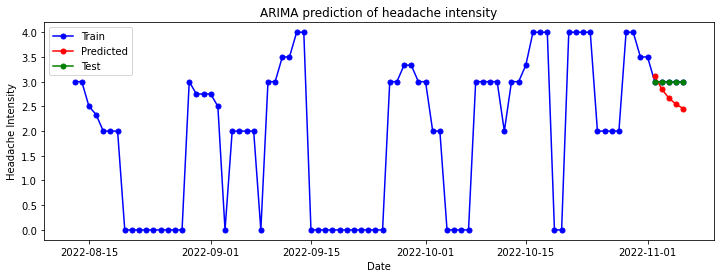

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Settings for accessing the API
BASE_URL = "YOUR URL HERE"
TOKEN = "YOUR TOKEN HERE"

headers = {
    "Authorization": f"Bearer {TOKEN}"
}


def fetch_data(endpoint):
    response = requests.get(f"{BASE_URL}{endpoint}", headers=headers)
    if response.status_code == 200:
        return pd.DataFrame(response.json())
    else:
        response.raise_for_status()

df = fetch_data("YOUR ENDPOINT HERE")
df = df.rename(columns={"_time": "ds"})
df['ds'] = pd.to_datetime(df['ds'], format="mixed").dt.tz_localize(None)
df.set_index('ds', inplace=True)


# Prepare the data
arima_df = df[['headache_intensity']].dropna()
#print(arima_df)
arima_df = arima_df.resample('D').mean().rolling(window=4, min_periods=1).mean().fillna(0)
#print(arima_df)

# Split the data into training and test sets (test set is the last 5 periods)
train_df = arima_df[:-5]
test_df = arima_df[-5:]

# Fit the ARIMA model
order = (1, 1, 1)
model = ARIMA(train_df['headache_intensity'], order=order)
model_fit = model.fit()

# Make predictions
test_forecast = model_fit.get_forecast(steps=5)
test_forecast_mean = test_forecast.predicted_mean

# Ensure indices align (MAPE doesn't work otherwise)
test_df = test_df.reset_index(drop=True)
test_forecast_mean = test_forecast_mean.reset_index(drop=True)

# Set headache intensity limit to 4.0
test_forecast_mean = test_forecast_mean.clip(upper=4.0)

# Calculate and print MSE, MAE, RMSE, MAPE
mse = mean_squared_error(test_df['headache_intensity'], test_forecast_mean)
mae = mean_absolute_error(test_df['headache_intensity'], test_forecast_mean)
rmse = mean_squared_error(test_df['headache_intensity'], test_forecast_mean, squared=False)
mape = np.mean(np.abs((test_df['headache_intensity'] - test_forecast_mean) / test_df['headache_intensity'])) * 100

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Convert to numpy arrays for plotting
full_ds = arima_df.index.values
full_y = arima_df['headache_intensity'].values
test_ds = arima_df.index[-5:].values
test_y = test_df['headache_intensity'].values
predicted_yhat = test_forecast_mean.values

# Make plot
plt.figure(figsize=(12, 4))
plt.plot(full_ds, full_y, 'bo-', label='Train', markersize=5)
plt.plot(test_ds, predicted_yhat, 'ro-', label='Predicted', markersize=5)
plt.plot(test_ds, test_y, 'go-', label='Test', markersize=5)
plt.xlabel('Date')
plt.ylabel('Headache Intensity')
plt.title('ARIMA prediction of headache intensity')
plt.legend()
plt.show()